# Plan-and-Execute

이 튜토리얼에서는 "plan-and-execute" 스타일의 에이전트를 만드는 방법을 소개하고, 이를 [LangGraph](https://langchain-ai.github.io/langgraph/)를 활용하여 구현하는 과정을 단계별로 설명합니다.  
"plan-and-execute" 전략은 복잡한 작업을 수행할 때 장기적인 계획을 먼저 수립한 뒤, 해당 계획을 단계별로 실행하며 필요에 따라 다시 계획을 재수정하는 접근법입니다.

![](./assets/langgraph-plan-and-execute.png)

---

## Plan-and-Execute란 무엇인가?

"plan-and-execute"는 다음과 같은 특징을 갖는 접근 방식입니다.

- **장기 계획 수립**: 복잡한 작업을 수행하기 전에 큰 그림을 그리는 장기 계획을 수립합니다.
- **단계별 실행 및 재계획**: 세운 계획을 단계별로 실행하고, 각 단계가 완료될 때마다 계획이 여전히 유효한지 검토한 뒤 수정할 수 있습니다.
  
이 방식은 [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)과 [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)에서 영감을 받았습니다. 전통적인 [ReAct 스타일](https://arxiv.org/abs/2210.03629)의 에이전트는 한 번에 한 단계씩 생각하는 반면, "plan-and-execute"는 명시적이고 장기적인 계획을 강조합니다.

**장점**:
1. **명시적인 장기 계획**: 강력한 LLM조차도 한 번에 장기 계획을 처리하는 데 어려움을 겪을 수 있습니다. 명시적으로 장기 계획을 수립함으로써, 보다 안정적인 진행이 가능합니다.
2. **효율적인 모델 사용**: 계획 단계에서는 더 큰/강력한 모델을 사용하고, 실행 단계에서는 상대적으로 작은/약한 모델을 사용함으로써 자원 소비를 최적화할 수 있습니다.

---

**주요 내용**

- **도구 정의**: 사용할 도구 정의
- **실행 에이전트 정의**: 실제 작업을 실행하는 에이전트 생성
- **상태 정의**: 에이전트의 상태 정의
- **계획 단계**: 장기 계획을 세우는 단계 생성
- **재계획 단계**: 작업 진행 상황에 따라 계획을 재수정하는 단계 생성
- **그래프 생성 및 실행**: 이러한 단계들을 연결하는 그래프 생성 및 실행

---

**참고**

- [LangGraph 공식 문서](https://langchain-ai.github.io/langgraph/)  
- [Plan-and-Solve 논문](https://arxiv.org/abs/2305.04091)  
- [Baby-AGI 프로젝트](https://github.com/yoheinakajima/babyagi)  
- [ReAct 논문](https://arxiv.org/abs/2210.03629)

지금부터는 각 단계를 따라가며 "plan-and-execute" 에이전트를 LangGraph로 구현하는 방법을 자세히 알아보겠습니다.

## 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


실습에 활용할 모델명 정의

In [6]:
from langchain_teddynote.models import get_model_name, LLMs

# 모델명 정의
#MODEL_NAME = get_model_name(LLMs.GPT4o)
MODEL_NAME = "gemini-2.5-pro"
MODEL_NAME

'gemini-2.5-pro'

## 도구 정의

사용할 도구를 먼저 정의합니다. 이 간단한 예제에서는 `Tavily`를 통해 제공되는 내장 검색 도구를 사용할 것입니다. 그러나 직접 도구를 만드는 것도 매우 쉽습니다. 

자세한 내용은 [도구(Tools)](https://wikidocs.net/262582) 문서를 참조하십시오.

In [4]:
from langchain_teddynote.tools import TavilySearch

# Tavily 검색 도구 초기화
tools = [TavilySearch(max_results=3)]

## 작업 실행 에이전트 정의

이제 작업을 실행할 `execution agent`를 생성합니다. 

이 예제에서는 각 작업에 동일한 `execution agent`를 사용할 예정이지만, 반드시 이렇게 해야 하는 것은 아닙니다.

In [7]:
#from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 정의
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer in Korean.",
        ),
        ("human", "{messages}"),
    ]
)


# LLM 정의
llm = ChatGoogleGenerativeAI(temperature=0, model=MODEL_NAME)

# ReAct 에이전트 생성
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [8]:
# 에이전트 실행
agent_executor.invoke(
    {"messages": [("user", "랭체인 한국어 튜토리얼에 대해서 설명해줘")]}
)

{'messages': [HumanMessage(content='랭체인 한국어 튜토리얼에 대해서 설명해줘', additional_kwargs={}, response_metadata={}, id='2f885b56-f57e-4e70-9dfd-579ecc71a2c2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_web_search', 'arguments': '{"query": "\\ub7ad\\uccb4\\uc778 \\ud55c\\uad6d\\uc5b4 \\ud29c\\ud1a0\\ub9ac\\uc5bc"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []}, id='run--b5152209-ac40-408f-bae4-fce01669d259-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '랭체인 한국어 튜토리얼'}, 'id': '1327adf2-6963-4dc4-a9bc-09bec7f2179d', 'type': 'tool_call'}]),
  ToolMessage(content='[{"url": "https://m.blog.naver.com/htk1019/223388363309", "title": "LangChain 공부하기 진짜진짜 좋은 자료 - 네이버 블로그", "content": "*My Menu 닫기* 본문 바로가기 * **본문 폰트 크기 조정** **<랭체인LangChain 노트> - LangChain 한국어 튜토리얼🇰🇷** \\\\*\\\\*추천\\\\*\\\\*은 공유할 수 있는 무료 전자책을 집필하는데 정말 큰 힘이 됩니다. 만들어 주신분께 감사드립니

## 상태 정의

- `input`: 사용자의 입력
- `plan`: 현재 계획
- `past_steps`: 이전에 실행한 계획과 실행 결과
- `response`: 최종 응답

In [14]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# 상태 정의
class PlanExecute(TypedDict):
    input: Annotated[str, "User's input"]
    plan: Annotated[List[str], "Current plan"]
    past_steps: Annotated[List[Tuple], operator.add]
    response: Annotated[str, "Final response"]

## 계획(Plan) 단계

이제 **계획 단계**를 생성하는 방법을 고려해 보겠습니다. 이 단계에서는 `function calling` 을 사용하여 계획을 수립합니다.

In [15]:
from pydantic import BaseModel, Field
from typing import List


# Plan 모델 정의
class Plan(BaseModel):
    """Sorted steps to execute the plan"""

    steps: Annotated[List[str], "Different steps to follow, should be in sorted order"]

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# 계획 수립을 위한 프롬프트 템플릿 생성
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
Answer in Korean.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
llm = ChatGoogleGenerativeAI(temperature=0, model="gemini-2.5-pro")
planner = planner_prompt | llm.with_structured_output(Plan)

`planner` 를 실행하여 계획을 수립한 결과를 확인합니다.

In [ ]:
# Planner 실행
planner.invoke(
    {
        "messages": [
            (
                "user",
                "LangGraph 의 핵심 장단점과 LangGraph 를 사용하는 이유는 무엇인가?",
            )
        ]
    }
)

## 재계획(Re-Plan) 단계

이제 이전 단계의 결과를 바탕으로 계획을 다시 수립하는 단계를 생성합니다.

In [18]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    # 사용자 응답
    response: str


class Act(BaseModel):
    """Action to perform."""

    # 수행할 작업: "Response", "Plan". 사용자에게 응답할 경우 Response 사용, 추가 도구 사용이 필요할 경우 Plan 사용
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


# 계획을 재수립하기 위한 프롬프트 정의
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

Answer in Korean."""
)


# Replanner 생성
replanner = replanner_prompt | ChatOpenAI(
    model=MODEL_NAME, temperature=0
).with_structured_output(Act)

## 그래프 생성

이제 그래프를 생성할 수 있습니다.

In [20]:
from langchain_core.output_parsers import StrOutputParser


# 사용자 입력을 기반으로 계획을 생성하고 반환
def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    # 생성된 계획의 단계 리스트 반환
    return {"plan": plan.steps}


# 에이전트 실행기를 사용하여 주어진 작업을 수행하고 결과를 반환
def execute_step(state: PlanExecute):
    plan = state["plan"]
    # 계획을 문자열로 변환하여 각 단계에 번호를 매김
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    # 현재 실행할 작업을 포맷팅하여 에이전트에 전달
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing [step 1. {task}]."""
    # 에이전트 실행기를 통해 작업 수행 및 결과 수신
    agent_response = agent_executor.invoke({"messages": [("user", task_formatted)]})
    # 이전 단계와 그 결과를 포함하는 딕셔너리 반환
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


# 이전 단계의 결과를 바탕으로 계획을 업데이트하거나 최종 응답을 반환
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    # 응답이 사용자에게 반환될 경우
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    # 추가 단계가 필요할 경우 계획의 단계 리스트 반환
    else:
        next_plan = output.action.steps
        if len(next_plan) == 0:
            return {"response": "No more steps needed."}
        else:
            return {"plan": next_plan}


# 에이전트의 실행 종료 여부를 결정하는 함수
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "final_report"
    else:
        return "execute"


final_report_prompt = ChatPromptTemplate.from_template(
    """You are given the objective and the previously done steps. Your task is to generate a final report in markdown format.
Final report should be written in professional tone.

Your objective was this:

{input}

Your previously done steps(question and answer pairs):

{past_steps}

Generate a final report in markdown format. Write your response in Korean."""
)

final_report = (
    final_report_prompt
    | ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0)
    | StrOutputParser()
)


def generate_final_report(state: PlanExecute):
    past_steps = "\n\n".join(
        [
            f"Question: {past_step[0]}\n\nAnswer: {past_step[1]}\n\n####"
            for past_step in state["past_steps"]
        ]
    )
    response = final_report.invoke({"input": state["input"], "past_steps": past_steps})
    return {"response": response}

## 그래프 생성

이제 지금까지 정의한 노드를 연결하여 그래프를 생성합니다.

In [21]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


# 그래프 생성
workflow = StateGraph(PlanExecute)

# 노드 정의
workflow.add_node("planner", plan_step)
workflow.add_node("execute", execute_step)
workflow.add_node("replan", replan_step)
workflow.add_node("final_report", generate_final_report)

# 엣지 정의
workflow.add_edge(START, "planner")
workflow.add_edge("planner", "execute")
workflow.add_edge("execute", "replan")
workflow.add_edge("final_report", END)

# 조건부 엣지: replan 후 종료 여부를 결정하는 함수 사용
workflow.add_conditional_edges(
    "replan",
    should_end,
    {"execute": "execute", "final_report": "final_report"},
)

# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

그래프를 시각화 합니다.

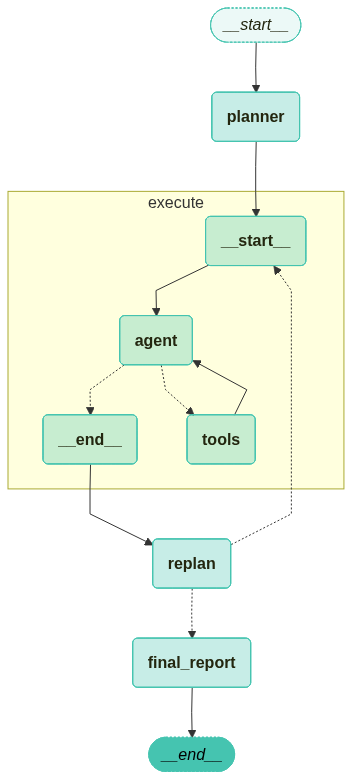

In [22]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app, xray=True)

## 그래프 실행

In [23]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

inputs = {
    "input": "Modular RAG 가 기존의 Naive RAG 와 어떤 차이가 있는지와 production level 에서 사용하는 이점을 설명해줘"
}

invoke_graph(app, inputs, config)


🔄 Node: planner 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Naive RAG의 기본 개념과 구성 요소를 설명합니다.
Modular RAG의 개념을 Naive RAG와 비교하여 설명하고, 추가되거나 변경된 모듈(예: 쿼리 변환, 라우팅, 재정렬)을 중심으로 상세히 설명합니다.
Production level에서 Modular RAG를 사용하는 것의 이점(성능, 확장성, 유지보수성 등)을 구체적인 예시와 함께 설명합니다.
두 RAG 방식의 차이점과 Modular RAG의 이점을 요약하여 최종 답변을 구성합니다.

🔄 Node: agent in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (19f00670-c6b0-4387-8cb4-380befcced29)
 Call ID: 19f00670-c6b0-4387-8cb4-380befcced29
  Args:
    query: Naive RAG 기본 개념

🔄 Node: tools in [execute] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"url": "https://day-to-day.tistory.com/76", "title": "Basic RAG를 실습 코드와 함께 알아보기 (feat. llamaIndex, langchain)", "content": "* langchain과 llamaIndex를 활용한 chromaDB로 Naive RAG 

NotFoundError: Error code: 404 - {'error': {'message': 'The model `gemini-2.5-pro` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [16]:
snapshot = app.get_state(config).values
print(snapshot["response"])

# Modular RAG와 Naive RAG의 차이점 및 Production Level에서의 이점

## 서론

RAG(Retrieval-Augmented Generation)는 정보 검색과 생성 모델을 결합하여 질문에 대한 답변을 생성하는 시스템입니다. 이 보고서에서는 Naive RAG와 Modular RAG의 차이점을 설명하고, Modular RAG가 production level에서 제공하는 이점을 구체적으로 살펴보겠습니다.

## Naive RAG의 개념 및 구성 요소

Naive RAG는 기본적으로 두 가지 주요 단계로 구성됩니다: 정보 검색과 답변 생성. 사용자가 질문을 입력하면, 시스템은 관련 문서를 검색하고, 검색된 문서를 기반으로 답변을 생성합니다. 이 방식은 구조가 단순하여 구현이 용이하지만, 복잡한 쿼리 처리나 다양한 데이터 소스의 통합에는 한계가 있을 수 있습니다.

### Naive RAG의 구성 요소

1. **질문 처리**: 사용자가 입력한 질문을 처리하여 검색에 적합한 형태로 변환합니다.
2. **정보 검색**: 질문과 관련된 문서를 검색합니다.
3. **문서 선택**: 검색된 문서 중에서 가장 관련성이 높은 문서를 선택합니다.
4. **답변 생성**: 선택된 문서를 기반으로 생성 모델이 답변을 생성합니다.
5. **결과 출력**: 생성된 답변을 사용자에게 제공합니다.

## Modular RAG의 개념 및 구성 요소

Modular RAG는 Naive RAG의 기본 구조에 여러 모듈을 추가하여 확장성을 높인 방식입니다. 주요 모듈로는 쿼리 변환, 라우팅, 재정렬 등이 있습니다. 이러한 모듈을 통해 더 복잡한 쿼리 처리와 다양한 데이터 소스의 통합을 가능하게 하며, 이는 성능과 확장성, 유지보수성 측면에서 큰 이점을 제공합니다.

### Modular RAG의 주요 모듈

1. **쿼리 변환 모듈**: 사용자의 질문을 보다 효과적으로 처리하기 위해 쿼리를 변환하거나 확장합니다.
2. **라우팅 모듈**: 다양한 데이터 소스나 검색 

In [17]:
from IPython.display import Markdown

Markdown(snapshot["response"])

# Modular RAG와 Naive RAG의 차이점 및 Production Level에서의 이점

## 서론

RAG(Retrieval-Augmented Generation)는 정보 검색과 생성 모델을 결합하여 질문에 대한 답변을 생성하는 시스템입니다. 이 보고서에서는 Naive RAG와 Modular RAG의 차이점을 설명하고, Modular RAG가 production level에서 제공하는 이점을 구체적으로 살펴보겠습니다.

## Naive RAG의 개념 및 구성 요소

Naive RAG는 기본적으로 두 가지 주요 단계로 구성됩니다: 정보 검색과 답변 생성. 사용자가 질문을 입력하면, 시스템은 관련 문서를 검색하고, 검색된 문서를 기반으로 답변을 생성합니다. 이 방식은 구조가 단순하여 구현이 용이하지만, 복잡한 쿼리 처리나 다양한 데이터 소스의 통합에는 한계가 있을 수 있습니다.

### Naive RAG의 구성 요소

1. **질문 처리**: 사용자가 입력한 질문을 처리하여 검색에 적합한 형태로 변환합니다.
2. **정보 검색**: 질문과 관련된 문서를 검색합니다.
3. **문서 선택**: 검색된 문서 중에서 가장 관련성이 높은 문서를 선택합니다.
4. **답변 생성**: 선택된 문서를 기반으로 생성 모델이 답변을 생성합니다.
5. **결과 출력**: 생성된 답변을 사용자에게 제공합니다.

## Modular RAG의 개념 및 구성 요소

Modular RAG는 Naive RAG의 기본 구조에 여러 모듈을 추가하여 확장성을 높인 방식입니다. 주요 모듈로는 쿼리 변환, 라우팅, 재정렬 등이 있습니다. 이러한 모듈을 통해 더 복잡한 쿼리 처리와 다양한 데이터 소스의 통합을 가능하게 하며, 이는 성능과 확장성, 유지보수성 측면에서 큰 이점을 제공합니다.

### Modular RAG의 주요 모듈

1. **쿼리 변환 모듈**: 사용자의 질문을 보다 효과적으로 처리하기 위해 쿼리를 변환하거나 확장합니다.
2. **라우팅 모듈**: 다양한 데이터 소스나 검색 엔진을 활용할 수 있도록 쿼리를 적절한 경로로 라우팅합니다.
3. **재정렬 모듈**: 검색된 문서나 생성된 답변을 사용자의 의도에 맞게 재정렬하여 최적의 결과를 제공합니다.

## Production Level에서 Modular RAG의 이점

### 성능 향상

- **정확한 정보 제공**: 최신 정보를 검색하고 이를 생성 모델에 제공하여 더 정확하고 신뢰할 수 있는 응답을 생성합니다.
- **효율적인 처리**: 검색 모듈이 필요한 정보를 사전에 필터링하여 생성 모델이 처리해야 할 데이터의 양을 줄임으로써, 처리 속도를 향상시킵니다.

### 확장성

- **모듈 교체 용이**: 각 모듈이 독립적으로 설계되어 있어, 특정 모듈을 업그레이드하거나 교체할 때 전체 시스템에 미치는 영향을 최소화할 수 있습니다.
- **다양한 데이터 소스 통합**: 여러 데이터 소스를 쉽게 통합할 수 있어, 다양한 유형의 데이터를 활용한 응답 생성이 가능합니다.

### 유지보수성

- **독립적 모듈 관리**: 각 모듈이 독립적으로 관리되므로, 특정 모듈에 문제가 발생했을 때 해당 모듈만 수정하거나 교체하면 됩니다.
- **버전 관리 용이**: 모듈별로 버전을 관리할 수 있어, 특정 기능이나 성능 개선을 위한 테스트 및 배포가 용이합니다.

## 결론

모듈형 RAG는 전통적인 RAG에 비해 더 큰 유연성과 확장성을 제공하여 다양한 응용 분야에 적합한 솔루션을 제공합니다. 특히 대규모 시스템에서 Modular RAG를 채택할 때, 시스템의 유연성과 효율성을 극대화하는 데 기여합니다. 이러한 이점들은 복잡한 쿼리 처리와 다양한 데이터 소스의 통합을 가능하게 하여, production level에서의 성능을 크게 향상시킵니다.

In [18]:
print(snapshot["response"])

# Modular RAG와 Naive RAG의 차이점 및 Production Level에서의 이점

## 서론

RAG(Retrieval-Augmented Generation)는 정보 검색과 생성 모델을 결합하여 질문에 대한 답변을 생성하는 시스템입니다. 이 보고서에서는 Naive RAG와 Modular RAG의 차이점을 설명하고, Modular RAG가 production level에서 제공하는 이점을 구체적으로 살펴보겠습니다.

## Naive RAG의 개념 및 구성 요소

Naive RAG는 기본적으로 두 가지 주요 단계로 구성됩니다: 정보 검색과 답변 생성. 사용자가 질문을 입력하면, 시스템은 관련 문서를 검색하고, 검색된 문서를 기반으로 답변을 생성합니다. 이 방식은 구조가 단순하여 구현이 용이하지만, 복잡한 쿼리 처리나 다양한 데이터 소스의 통합에는 한계가 있을 수 있습니다.

### Naive RAG의 구성 요소

1. **질문 처리**: 사용자가 입력한 질문을 처리하여 검색에 적합한 형태로 변환합니다.
2. **정보 검색**: 질문과 관련된 문서를 검색합니다.
3. **문서 선택**: 검색된 문서 중에서 가장 관련성이 높은 문서를 선택합니다.
4. **답변 생성**: 선택된 문서를 기반으로 생성 모델이 답변을 생성합니다.
5. **결과 출력**: 생성된 답변을 사용자에게 제공합니다.

## Modular RAG의 개념 및 구성 요소

Modular RAG는 Naive RAG의 기본 구조에 여러 모듈을 추가하여 확장성을 높인 방식입니다. 주요 모듈로는 쿼리 변환, 라우팅, 재정렬 등이 있습니다. 이러한 모듈을 통해 더 복잡한 쿼리 처리와 다양한 데이터 소스의 통합을 가능하게 하며, 이는 성능과 확장성, 유지보수성 측면에서 큰 이점을 제공합니다.

### Modular RAG의 주요 모듈

1. **쿼리 변환 모듈**: 사용자의 질문을 보다 효과적으로 처리하기 위해 쿼리를 변환하거나 확장합니다.
2. **라우팅 모듈**: 다양한 데이터 소스나 검색 